# Limit order book (LOB) simulation

**Change the sim to build in the following new features based on https://arxiv.org/abs/1311.6262 and https://arxiv.org/abs/1105.1694**:

Using [Bouchaud et al. (2018)](https://doi.org/10.1017/9781316659335) and the original Santa Fe model of [Smith et al. (2006)](https://www.tandfonline.com/doi/abs/10.1088/1469-7688/3/6/307) as the main references here.

The simulation of financial markets through the use of agent-based models is an increasingly popular technique to understand the microstructure of their dynamics from the bottom up. In this notebook, we'll look at an example market simulation.

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Get the class structures
import sys
sys.path.append("/Users/Rob/work/finmarbs/src/")
from lobsim import LOBsim
from agents import agentens

## A synchronous ensemble version of the $\epsilon$-intelligence model

Begin with a **heterogeneous individual-agent** version of the $\epsilon$-intelligence extension to the original Santa Fe model using a synchronous ensemble rejection algorithm. The key point here is to make sure the overall holding rate is large enough which should limit the number of anachronisms in the order flow...

In [2]:
setup = {
    # Initial bid tick
    "initbidpricetick" : 498,
    # Initial ask tick
    "initaskpricetick" : 502,
    # The price tick size
    "tickscale" : 0.01,
    # The number of price points simulated
    "Nlattice" : 1000,
    # Number of liquidity providing agents
    "Nproviders" : 50,
    # Number of liquidity taking agents
    "Ntakers" : 50,
    # The 'alpha' parameter of the limit order aggression
    # beta distribution across agents
    "LOaggrA" : 0.5,
    # The 'beta' parameter of the limit order aggression
    # beta distribution across agents
    "LOaggrB" : 5.0,
    # The 'alpha' parameter of the market order aggression
    # beta distribution across agents
    "MOaggrA" : 5.0,
    # The 'beta' parameter of the market order aggression
    # beta distribution across agents
    "MOaggrB" : 0.5,
    # The strength of anti-correlation between market orders
    # and limit orders on the same book side for each agent 
    "LOsignalpha" : 0.5,
    # The Pareto power law value for market order volumes
    "MOvolpower" : 0.5,
    # The Pareto power law value for market order volumes
    "MOvolcutoff" : 100,
    # Mean limit order rate per agent on the bid side
    "meanLOratebid" : 4.5,
    # Mean limit order rate per agent on the ask side
    "meanLOrateask" : 4.5,
    # Mean market order rate per agent on the bid side
    "meanMOratebid" : 4.0,
    # Mean market order rate per agent on the ask side
    "meanMOrateask" : 4.0,
    # Mean cancel order rate per agent on the bid side
    "meanCOratebid" : 4.0,
    # Mean cancel order rate per agent on the ask side
    "meanCOrateask" : 4.0,
    # The overall mean holding rate
    "meanHOrate" : 10.0,
    # Limit order mean rate decay power in price units
    "meanLOdecay" : 5.0,
}

# Initialise the LOB simulation
los = LOBsim(setup, agentens=agentens)

# Iterate the LOB over time
burn_in = 50.0
tend, t = 5000.0, 0.0
midps = []
while t < tend:
    los.iterate()
    t = los.time
    midps.append([t, los.market_state_info["midprice"]])

# Create time series using the mid price output data
df = pd.DataFrame(midps, columns=['Time', 'Mid price'])
df = df[df.Time > burn_in]

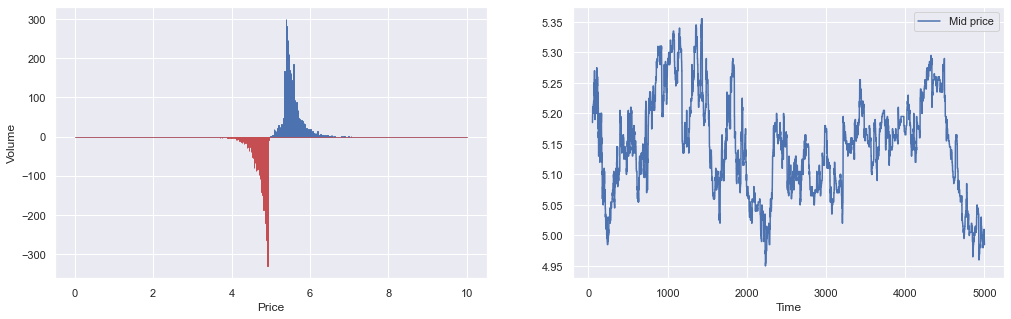

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(17, 5))
ax[0].bar(los.prices, los.asks, width=setup["tickscale"], edgecolor='b')
ax[0].bar(los.prices, -los.bids, width=setup["tickscale"], edgecolor='r')
df.set_index('Time').plot(ax=ax[1])
ax[0].set_ylabel('Volume')
ax[0].set_xlabel('Price')
plt.show()

From here we need to list off the different rates and effects we are adding and why based on many of the stylised facts for real stock markets.

The conditional master equation for the process above at price $p$ and $N$ agents can hence be approximated as

$$
\begin{align}
\frac{{\rm d}}{{\rm d}t}&P_p[\dots, V^p_{ib}, \dots, V^p_{ia}, \dots, t\vert a(t), b(t)] \simeq \\
& \sum_{i=1}^N\sum^\infty_{S=1}\lambda^p_{ib}[a(t),b(t),t] P_\lambda (S) P_p[\dots, V^p_{ib}-S, \dots, V^p_{ia}, \dots, t\vert a(t), b(t)] \\
&+ \sum_{i=1}^N\sum^\infty_{S=1}\lambda^p_{ia}[a(t),b(t),t] P_\lambda (S) P_p[\dots, V^p_{ib}, \dots, V^p_{ia}-S, \dots, t\vert a(t), b(t)] \\
&+ \sum_{i=1}^N\sum^{V^p_{ib}}_{S=1}\frac{(V^p_{ib}+S)\sum_{i'=1}^N\mu^p_{i'b}[a(t),b(t),t]}{S+\sum_{i'=1}^NV^p_{i'b}} P_\mu (S) P_p[\dots, V^p_{ib}+S, \dots, V^p_{ia}, \dots, t\vert a(t), b(t)] \\
&+ \sum_{i=1}^N\sum^{V^p_{ia}}_{S=1}\frac{(V^p_{ia}+S)\sum_{i'=1}^N\mu^p_{i'a}[a(t),b(t),t]}{S+\sum_{i'=1}^NV^p_{i'a}} P_\mu (S) P_p[\dots, V^p_{ib}, \dots, V^p_{ia}+S, \dots, t\vert a(t), b(t)] \\
&+ \sum_{i=1}^N(V^p_{ib}+1)\nu_{ib}(t) P_p[\dots, V^p_{ib}+1, \dots, V^p_{ia}, \dots, t\vert a(t), b(t)] \\
&+ \sum_{i=1}^N(V^p_{ia}+1)\nu_{ia}(t) P_p[\dots, V^p_{ib}, \dots, V^p_{ia}+1, \dots, t\vert a(t), b(t)] \\
&- \sum_{i=1}^N
\bigg( \lambda^p_{ib}[a(t),b(t),t] + \lambda^p_{ia}[a(t),b(t),t] + \mu^p_{ib}[a(t),b(t),t] \\
& \qquad + \mu^p_{ia}[a(t),b(t),t] + V^p_{ib}\nu_{ib}(t) + V^p_{ia}\nu_{ia}(t) \bigg) P_p[\dots, V^p_{ib}, \dots, V^p_{ia}, \dots, t\vert a(t), b(t)]\,,
\end{align}
$$

where $m(t)=[b(t)+a(t)]/2$ is the mid price and the other rate functions are

$$
\begin{align}
\lambda^p_{ib}[a(t),b(t),t] &= \lambda_b \gamma^\lambda_{ib}(t)k^\lambda_{ib}[m(t),t]\mathbb{1}_{m(t)\geq p} e^{-\alpha [m(t)-p]} \\
\lambda^p_{ia}[a(t),b(t),t] &= \lambda_a \gamma^\lambda_{ia}(t)k^\lambda_{ia}[m(t),t]\mathbb{1}_{p\geq m(t)} e^{-\alpha [p-m(t)]} \\ 
\mu^p_{ib}[a(t),b(t),t] &= \mu_b\gamma^\mu_{ib}(t)k^\mu_{ib}[m(t),t]\mathbb{1}_{a(t)= p} \\
\mu^p_{ia}[a(t),b(t),t] &= \mu_a\gamma^\mu_{ia}(t)k^\mu_{ia}[m(t),t]\mathbb{1}_{b(t)= p} \\
\nu_{ib}(t) &= \nu_b\gamma^\nu_{ib}(t) \\
\nu_{ia}(t) &= \nu_a\gamma^\nu_{ia}(t) \,,
\end{align}
$$

where: $\lambda_b\,, \lambda_a$ are the average limit order rates per agent; $\alpha$ is the limit order decay power; $\mu_b\,, \mu_a$ are the average market order rates per agent; $\nu_b\,, \nu_a$ are the average order-cancellation rates per agent; and $\gamma^\lambda_{ib}(t), \gamma^\lambda_{ia}(t), \gamma^\mu_{ib}(t), \gamma^\mu_{ib}(t)$ model the $i$-th agents' preferred relative trading rates, which we draw in each case from a unit-mean and $1/k$-variance gamma distribution, i.e., ${\rm PDF}(\gamma^x_{iy})={\rm Gamma}(\gamma^x_{iy};k,k)$ and refresh for each agent at a mean speculation rate of $r$. Note that we denote $\mathbb{1}_A$ as an indicator function which takes value unity when $A$ is true, else 0.

Let us now approximate the volume fractions to be the following time-dependent stochastic processes which are uncorrelated to the $i$-th agent's actions

$$
\begin{equation}
F^p_{ib}(t) \simeq F^p_{ib}(V^p_{ib}, t) = \frac{V^p_{ib}(t)+1}{1+\sum_{i'=1}^NV^p_{i'b}(t)}\,, \qquad F^p_{ia}(t) \simeq F^p_{ia}(V^p_{ia}, t) = \frac{V^p_{ia}(t)+1}{1+\sum_{i'=1}^NV^p_{i'a}(t)}\,,
\end{equation}
$$

and which satisfy the constraints $\sum^N_{i=1}F^p_{ib}(t)=1$ and $\sum^N_{i=1}F^p_{ia}(t)=1$. By then marginalising over the full master equation bid and ask volumes $\forall i'\neq i$, we can hence obtain an approximate equation for each individual agent

$$
\begin{align}
\frac{{\rm d}}{{\rm d}t}P(V^p_{ib}, V^p_{ia}, t) &\simeq \gamma^\lambda_{ib}(t)\lambda^p_b(t) P(V^p_{ib}-1, V^p_{ia}, t) + \gamma^\lambda_{ia}(t)\lambda^p_a(t) P(V^p_{ib}, V^p_{ia}-1, t) \\
&+ F^p_{ib}(t)\sum^N_{i'=1}\gamma^\mu_{i'b}(t)\mu^p_{b}(t)P(V^p_{ib}+1, V^p_{ia}, t) + F^p_{ia}(t)\sum^N_{i'=1}\gamma^\mu_{i'a}(t)\mu^p_{a}(t)P(V^p_{ib}, V^p_{ia}+1, t) \\
&+ (V^p_{ib}+1)\nu_b P(V^p_{ib}+1, V^p_{ia}, t) + (V^p_{ia}+1)\nu_a P(V^p_{ib}, V^p_{ia}+1, t) \\
&- \bigg\{ \gamma^\lambda_{ib}(t)\lambda^p_b(t) + \gamma^\lambda_{ia}(t)\lambda^p_a(t) + F^p_{ib}(t)\sum^N_{i'=1}\gamma^\mu_{i'b}(t)\mu^p_{b}(t) + F^p_{ia}(t)\sum^N_{i'=1}\gamma^\mu_{i'a}(t)\mu^p_{a}(t) + V^p_{ib}\nu_b + V^p_{ia}\nu_a \bigg\} P(V^p_{ib}, V^p_{ia}, t)\,.
\end{align}
$$

Taking the first moments of this equation with respect to $V^p_{ia}$ and $V^p_{ib}$ in turn, we then obtain the probability mass function solution of two independent time-inhomogeneous Poisson processes

$$
\begin{align}
P(V^p_{ib}, V^p_{ia}, t) &\simeq {\rm Poisson}\big[ V^p_{ib};{\rm E}_{t}(V^p_{ib})\big] {\rm Poisson}\big[ V^p_{ia};{\rm E}_{t}(V^p_{ia})\big] \\
{\rm E}_{t}(V^p_{ib}) &\simeq {\rm E}_{t_0}(V^p_{ib})e^{- \nu_b(t-t_0)} +  \int_{t_0}^t {\rm d}t' \bigg[ \gamma^\lambda_{ib}(t')\lambda^p_b(t') - F^p_{ib}(t')\sum^N_{i'=1}\gamma^\mu_{i'b}(t')\mu^p_{b}(t')\bigg] e^{-\nu_b(t-t')} \\
{\rm E}_{t}(V^p_{ia}) &\simeq {\rm E}_{t_0}(V^p_{ia})e^{- \nu_a(t-t_0)} +  \int_{t_0}^t {\rm d}t' \bigg[ \gamma^\lambda_{ia}(t')\lambda^p_a(t') - F^p_{ia}(t')\sum^N_{i'=1}\gamma^\mu_{i'a}(t')\mu^p_{a}(t')\bigg] e^{-\nu_a(t-t')} \,.
\end{align}
$$

Note that by summing over $i$, we obtain an approximate description of the volume queue at each price $p$. Furthermore, we may infer that the probabilities for a price having non-zero bid or ask volume, respectively, at time $t$ are given by

$$
\begin{equation}
P\bigg( \sum_{i=1}^NV^p_{ib}>0, t\bigg) = 1-e^{-\sum_{i=1}^N{\rm E}_{t}(V^p_{ib})}\,, \qquad P\bigg( \sum_{i=1}^NV^p_{ia}>0, t\bigg) = 1-e^{-\sum_{i=1}^N{\rm E}_{t}(V^p_{ia})}\,.
\end{equation}
$$

<ipython-input-4-5e7c84678482>:18: RuntimeWarning: divide by zero encountered in log
  np.log(f[::-1]),
<ipython-input-4-5e7c84678482>:18: RuntimeWarning: divide by zero encountered in log
  np.log(f[::-1]),
<ipython-input-4-5e7c84678482>:18: RuntimeWarning: divide by zero encountered in log
  np.log(f[::-1]),
<ipython-input-4-5e7c84678482>:18: RuntimeWarning: divide by zero encountered in log
  np.log(f[::-1]),


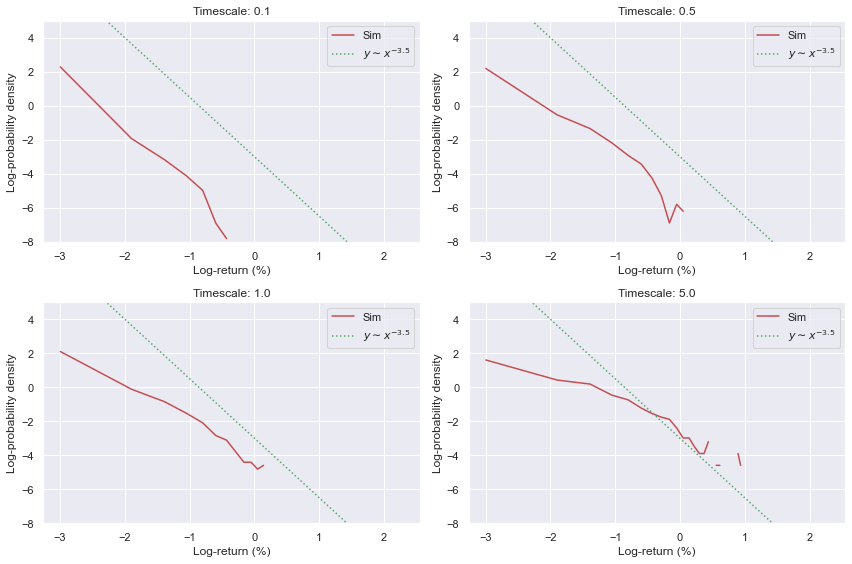

In [4]:
dts = [0.1, 0.5, 1.0, 5.0] # Time periods 
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
axs = [ax[0, 0], ax[0, 1], ax[1, 0], ax[1, 1]]
for dt, ax in zip(dts, axs):
    df_asof = df.set_index('Time').asof(
        np.arange(dt, tend, dt)
    )
    perc_returns = 100.0 * (
        df_asof.diff().shift(-1) / df_asof
    ).iloc[:-1].values
    f, b = np.histogram(
        np.abs(perc_returns),  
        density=True,
        bins=np.arange(0.0, 10.0, 0.1)
    )
    ax.plot(
        np.log(0.5*(b[1:]+b[:-1])[::-1]), 
        np.log(f[::-1]),
        color='r',
        label='Sim',
    )
    ax.plot(
        np.log(0.5*(b[1:]+b[:-1])[::-1]),
        -3.5*np.log(0.5*(b[1:]+b[:-1])[::-1]) - 3.0,
        ':',
        color='g',
        label=r'$y\sim x^{-3.5}$',
    )
    ax.legend()
    ax.set_ylim([-8.0, 5.0])
    ax.set_ylabel('Log-probability density')
    ax.set_xlabel('Log-return (%)')
    ax.set_title('Timescale: ' + str(dt))
plt.tight_layout()
plt.show()

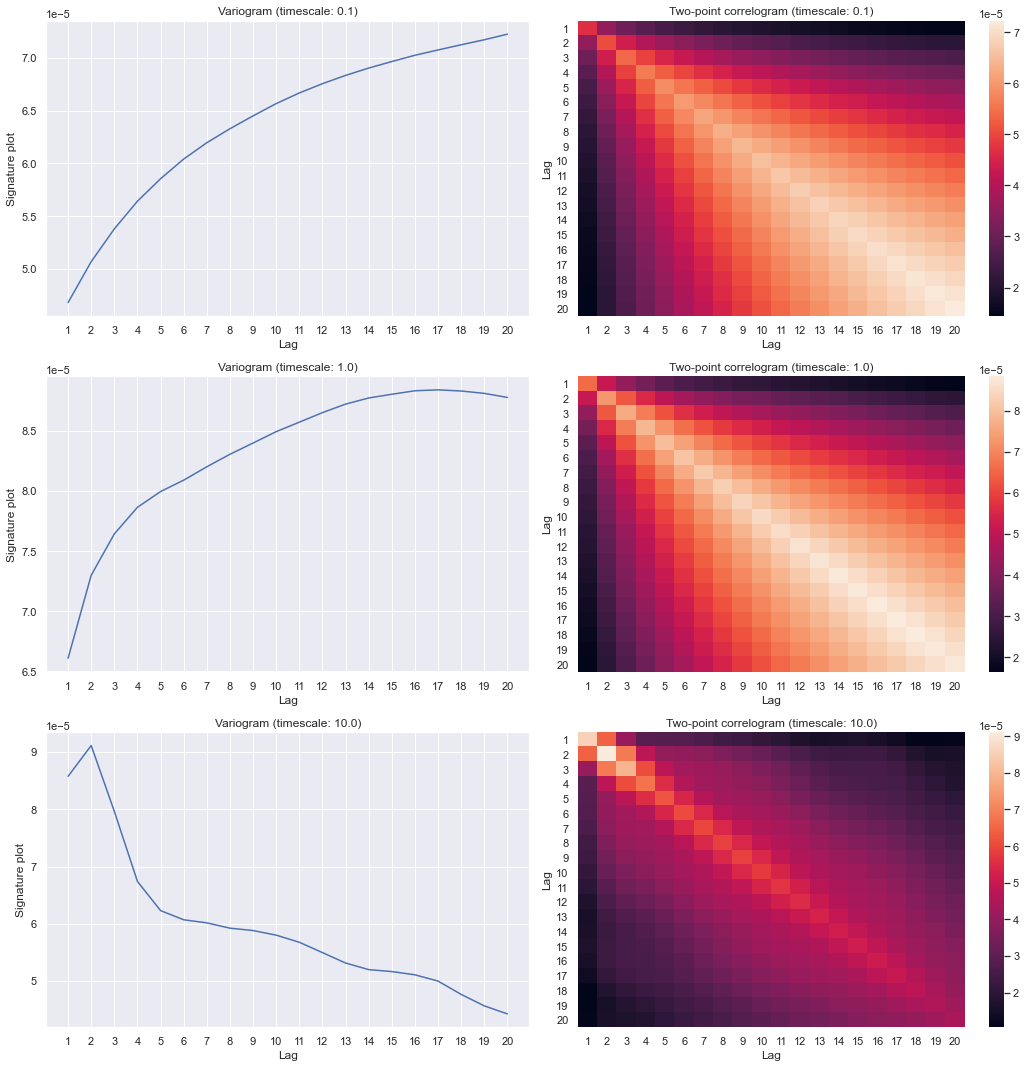

In [5]:
nlags = 20
dts = [0.1, 1.0, 10.0] # Time periods
fig, ax = plt.subplots(3, 2, figsize=(15, 15))
axs = [ax[0], ax[1], ax[2]]
for dt, ax in zip(dts, axs):
    df_asof = df.set_index('Time').asof(
        np.arange(dt, tend, dt)
    )
    pmsq = df_asof.mean() ** 2
    c = np.zeros(nlags)
    cc = np.zeros((nlags, nlags))
    for lag1 in range(1, nlags + 1):
        s1 = df_asof - df_asof.shift(lag1)
        s2 = df_asof - df_asof.shift(lag1)
        c[lag1-1] = (
            (s1 * s2).mean()
            / (dt * lag1)
        )
        for lag2 in range(1, nlags + 1):
            s2 = df_asof - df_asof.shift(lag2)
            cc[lag1-1, lag2-1] = (
                (s1 * s2).mean()
                / (dt * np.sqrt(lag1) * np.sqrt(lag2))
            )
    ax[0].plot(range(1, nlags + 1), c)
    sns.heatmap(cc, ax=ax[1])
    ax[0].set_xticks(range(1, nlags + 1))
    ax[1].set_xticklabels(range(1, nlags + 1))
    ax[1].set_yticklabels(range(1, nlags + 1))
    ax[0].set_xlabel('Lag')
    ax[0].set_ylabel('Signature plot')
    ax[1].set_xlabel('Lag')
    ax[1].set_ylabel('Lag')
    ax[0].set_title(
        'Variogram (timescale: ' + str(dt) + ')'
    )
    ax[1].set_title(
        'Two-point correlogram (timescale: ' + str(dt) + ')'
    )
plt.tight_layout()
plt.show()